In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Import

In [2]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

In [25]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()
moduledf

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_80988/1282985453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf.drop('module_type', axis =1, inplace=True)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_80988/1282985453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf['tags'] = moduledf['tags'].str.lower()


,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability
0,Other/unknown,Resonant Lowpass Gate,12.0,105.0,15.0,13.0,0.0,120.0,4.0,filter-low pass gate-vca,unknown
1,Other/unknown,BiMix,4.0,50.0,15.0,15.0,0.0,117.0,89.0,attenuator-mixer-polarizer,unknown
2,Other/unknown,Thomas White Dual Resonant Lopass Gate,12.0,105.0,32.0,30.0,0.0,234.0,422.0,low pass gate-filter-vca-mixer-dual/stereo,unknown
3,Other/unknown,The Squarewave Parade CONVERT,4.0,NaN,NaN,NaN,NaN,NaN,3.0,external-utility,unknown
4,Other/unknown,DIY 2 HP Switches,2.0,10.0,NaN,NaN,NaN,15.0,42.0,switch,unknown
...,...,...,...,...,...,...,...,...,...,...,...
15530,XOXO Modular,Five Finger Fuzz,4.0,13.0,NaN,NaN,NaN,27.0,16.0,distortion-effect-fuzz,avail
15531,XOXO Modular,Makrophonie (Black & Gold Panel),5.0,33.0,16.0,25.0,NaN,72.0,8.0,distortion-effect-preamp,avail
15532,XOXO Modular,IXO (Black & Gold Panel),2.0,17.0,NaN,NaN,NaN,66.0,42.0,midi-utility,avail
15533,XOXO Modular,QUADBOOL,5.0,35.0,NaN,NaN,NaN,NaN,13.0,logic,proto


# Inspect data

## Classifying missing data

In [26]:
moduledf.isna().sum()
#missing current and depth info OK
#tags and price are important factors

manufacturer_name       0
module_name             0
width                   0
depth                3256
current_plus12V      3694
current_minus12V     4314
current_5V           6107
price                2402
num_racks               0
tags                   71
availability            0
dtype: int64

In [27]:
#Check the types of modules which are missing prices
moduledf[moduledf.price.isnull()].groupby('tags').size().sort_values(ascending=False)

tags
blank panel                                               179
filter                                                     89
oscillator                                                 83
drum                                                       81
utility                                                    65
                                                         ... 
delay-filter                                                1
delay-filter-low pass gate-mixer-oscillator-random-vca      1
delay-filter-synth voice                                    1
delay-lfo                                                   1
waveshaper-utility                                          1
Length: 891, dtype: int64

In [31]:
# many are blank panels (for filling space, not devices). These can be dropped.
moduledf = moduledf[moduledf.tags != 'blank panel']

<AxesSubplot:ylabel='availability'>

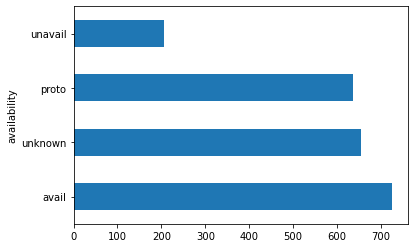

In [32]:
moduledf[moduledf.price.isnull()].groupby('availability').size().sort_values(ascending=False).plot(kind='barh') #many are unavailable or prototypes

In [33]:
#find out if items with missing price are popular
moduledf[moduledf.price.isnull()].sort_values(ascending=False, by = 'num_racks')

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability
5583,Arturia,RackBrute 6U/3U Power,5.0,80.0,NaN,NaN,NaN,NaN,17124.0,power,avail
9333,Instruō,arbhar expander,2.0,NaN,NaN,NaN,NaN,NaN,6431.0,expander,proto
9332,Instruō,Lúbadh expander,2.0,38.0,NaN,NaN,NaN,NaN,3236.0,sampling-expander,avail
14355,Tiptop Audio,Z8000 MK1,28.0,59.0,70.0,70.0,0.0,NaN,2428.0,cv modulation-sequencer,unavail
8962,Grayscale,Ornament & Crime (Grayscale panel),14.0,25.0,85.0,10.0,NaN,NaN,2202.0,digital-quad,avail
...,...,...,...,...,...,...,...,...,...,...,...
2250,Other/unknown,Synthmar - Jump,4.0,15.0,NaN,NaN,NaN,NaN,1.0,utility,proto
4076,Other/unknown,Vactrol-LPG,2.0,40.0,NaN,NaN,NaN,NaN,1.0,low pass gate,proto
686,Other/unknown,Switchable Multiple,6.0,20.0,NaN,NaN,NaN,NaN,1.0,multiple,unknown
278,Other/unknown,Menage a trois,12.0,NaN,NaN,NaN,NaN,NaN,0.0,switch,unknown


In [66]:
#Some of the parts with missing price are just power supplies, or expanders (optional modules which come packaged with another)
#These can be dropped
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Re-check for popular items with missing price
moduledf[moduledf.price.isnull()].sort_values(ascending=False, by = 'num_racks').head(20)
#9 of the top 20 popular devices with missing devices are prototypes or unavailable, restrict attention to available devices

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability
14355,Tiptop Audio,Z8000 MK1,28.0,59.0,70.0,70.0,0.0,NaN,2428.0,cv modulation-sequencer,unavail
8962,Grayscale,Ornament & Crime (Grayscale panel),14.0,25.0,85.0,10.0,NaN,NaN,2202.0,digital-quad,avail
9007,Grayscale,uO_c (black panel),8.0,25.0,85.0,10.0,0.0,NaN,1957.0,cv modulation-digital-quad,proto
14660,Verbos Electronics,Multiple,3.0,NaN,NaN,NaN,NaN,NaN,1781.0,multiple,unknown
14424,Tiptop Audio,Buchla 292t,16.0,NaN,NaN,NaN,NaN,NaN,1677.0,low pass gate-quad,proto
14426,Tiptop Audio,Buchla 266t,24.0,NaN,NaN,NaN,NaN,NaN,1507.0,cv modulation-quantizer-random-noise-sample an...,proto
8970,Grayscale,Maths v2 (Grayscale black panel),20.0,24.0,60.0,50.0,0.0,NaN,1489.0,clock generator-cv modulation-envelope generat...,avail
14765,vpme.de,Euclidean Circles,10.0,25.0,0.0,0.0,70.0,NaN,1451.0,clock modulator-frequency divider-sequencer-ra...,unknown
14428,Tiptop Audio,Buchla 245t,30.0,NaN,NaN,NaN,NaN,NaN,1379.0,clock generator-sequencer-quad,proto
9006,Grayscale,uO_c (aluminum panel),8.0,25.0,85.0,10.0,0.0,NaN,1352.0,cv modulation-digital-quad,proto


In [67]:
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')
moduledf[moduledf.price.isnull()].groupby('brand_known').size() #and about half come from unknown brands

brand_known
False     912
True     1156
dtype: int64

In [70]:
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]
df_brands.price.isnull().sum() / len(df_brands) * 100
#about 10% of price data is missing for products from main brands for non-prototype/unavailable products

10.296191819464035

In [76]:
df_brands[df_brands.price.isnull()].sort_values(by = 'num_racks', ascending=False).head(30)
#inspecing many of these manually, most are replicas or units which have been replaced by newer versions
#For example, Grayscale seems to mostly produce homemade remakes 

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability,brand_known
8962,Grayscale,Ornament & Crime (Grayscale panel),14.0,25.0,85.0,10.0,NaN,NaN,2202.0,digital-quad,avail,True
14660,Verbos Electronics,Multiple,3.0,NaN,NaN,NaN,NaN,NaN,1781.0,multiple,unknown,True
8970,Grayscale,Maths v2 (Grayscale black panel),20.0,24.0,60.0,50.0,0.0,NaN,1489.0,clock generator-cv modulation-envelope generat...,avail,True
14765,vpme.de,Euclidean Circles,10.0,25.0,0.0,0.0,70.0,NaN,1451.0,clock modulator-frequency divider-sequencer-ra...,unknown,True
8403,Expert Sleepers,Select Bus breakout,4.0,23.0,9.0,0.0,0.0,NaN,956.0,midi-utility,avail,True
13103,Robaux,LL8,10.0,25.0,20.0,0.0,0.0,NaN,919.0,clock generator-digital-drum-sequencer,avail,True
8905,Grayscale,Turing Machine - Grayscale Hybrid Panel,26.0,43.0,NaN,NaN,NaN,NaN,867.0,random-sequencer,unknown,True
5516,Antumbra,MULT,4.0,20.0,NaN,NaN,NaN,NaN,821.0,multiple,avail,True
8918,Grayscale,Music Thing Radio Music,4.0,40.0,60.0,8.0,0.0,NaN,791.0,sampling,unknown,True
12880,Random*Source,Haible Tau Phaser,18.0,30.0,80.0,80.0,NaN,NaN,780.0,phase shifter-effect,avail,True


In [81]:
df_brands[df_brands.price.isnull()].groupby('manufacturer_name').size().sort_values(ascending=False).head(15)

manufacturer_name
Barton Musical Circuits     69
ST Modular                  64
Nonlinearcircuits           50
Blue Lantern Modules        38
Million Machine March       35
Grayscale                   32
Fitzgreyve Synthesis        16
Hexinverter Électronique    15
Falafular                   14
Befaco                      13
Złob                        13
333modules                  12
CGS                         11
MFOS                        10
X-Fade Modular               9
dtype: int64

In [82]:
moduledf[moduledf.manufacturer_name == 'Grayscale'] #ex: grayscale products are remakes with different face plates

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability,brand_known
8858,Grayscale,4ms PEG (Grayscale panel),20.0,NaN,105.0,35.0,0.0,345.0,455.0,envelope generator-cv modulation-dual/stereo-lfo,unknown,True
8859,Grayscale,Make Noise Wogglebug (Grayscale panel),14.0,24.0,50.0,40.0,NaN,270.0,395.0,clock generator-clock modulator-cv modulation-...,unknown,True
8860,Grayscale,Cyclebox (Grayscale panel),16.0,NaN,110.0,0.0,0.0,500.0,79.0,oscillator,unknown,True
8861,Grayscale,Ardcore (Grayscale panel),10.0,NaN,42.0,22.0,NaN,330.0,69.0,digital,unknown,True
8862,Grayscale,4ms RCD (Grayscale panel),4.0,48.0,60.0,35.0,0.0,179.0,647.0,clock modulator,unknown,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9017,Grayscale,POKIT,42.0,18.0,NaN,NaN,NaN,95.0,38.0,controller-midi-sequencer,avail,True
9018,Grayscale,Make Noise Mimeophon (Grayscale aluminum panel),16.0,30.0,100.0,100.0,0.0,399.0,226.0,delay-digital-dual/stereo-effect,avail,True
9019,Grayscale,Make Noise Mimeophon (Grayscale matte black pa...,16.0,30.0,100.0,100.0,0.0,NaN,273.0,delay-digital-dual/stereo-effect,avail,True
9020,Grayscale,Make Noise X-Pan (Grayscale aluminum panel),10.0,30.0,145.0,110.0,0.0,NaN,90.0,dual/stereo-mixer-panning-vca,avail,True


In [83]:
moduledf[moduledf.manufacturer_name == 'Barton Musical Circuits'] #grayscale products are remakes with different face plates

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability,brand_known
5650,Barton Musical Circuits,Dual Quantizer (Barton),4.0,50.0,40.0,30.0,NaN,65.0,46.0,quantizer-dual/stereo,unknown,True
5651,Barton Musical Circuits,Dual Decaying Noise,10.0,NaN,NaN,NaN,NaN,105.0,46.0,noise-dual/stereo,unknown,True
5652,Barton Musical Circuits,CV Arpeggiator,8.0,NaN,NaN,NaN,NaN,NaN,45.0,cv modulation-sequencer,unknown,True
5653,Barton Musical Circuits,Analog Drum,8.0,NaN,5.0,5.0,NaN,16.0,161.0,drum,unknown,True
5654,Barton Musical Circuits,Dual Nice Quantizer,14.0,NaN,NaN,NaN,NaN,NaN,65.0,quantizer-dual/stereo,unknown,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5752,Barton Musical Circuits,BMC43 4X Decay,8.0,NaN,NaN,NaN,NaN,97.0,8.0,envelope generator-quad,avail,True
5753,Barton Musical Circuits,BMC75 - Envelope Follower,6.0,NaN,NaN,NaN,NaN,86.0,18.0,envelope follower,avail,True
5754,Barton Musical Circuits,BMC083. VC Delay,8.0,NaN,NaN,NaN,NaN,NaN,27.0,delay,avail,True
5755,Barton Musical Circuits,BMC51 Preset Rhythms,10.0,NaN,NaN,NaN,NaN,24.0,10.0,clock generator-sequencer,avail,True
